# What are predictors of life expectancy in the US and other countries?
## by David Mullen

## Preliminary Wrangling

My dataset will require quite a bit of extra wrangling, but I'm hoping the results will be interesting and worth the effort. I'm pulling primarily from Gapminder, and I'll be joining several tables from this dataset. We will look at population, as well as several statistics for healthcare spending, and I am also pulling data on which countries have universal healthcare, and also what continents countries are in from the respective Wikipedia pages. This categorical information will be another way to slice our data to look for conclusions.

In [1]:
# import all packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import statsmodels.api as sm
from bs4 import NavigableString, BeautifulSoup
import os

# set plots to be embedded inline
%matplotlib inline

In [2]:
# CSV IMPORTATION *******************
# Gapminder tables have a row of column headers and an index colum

#life expectancy
le_filename = 'data/life_expectancy_years.csv'
le = pd.read_csv(le_filename, header=0, index_col=0)

#inflation adjusted income per person
ic_filename = 'data/income_per_person_gdppercapita_ppp_inflation_adjusted.csv'
ic = pd.read_csv(ic_filename, header=0, index_col=0)

#out of pocket percent of total health spending
op_filename = 'data/out_of_pocket_share_of_total_health_spending_percent.csv'
op = pd.read_csv(op_filename, header=0, index_col=0)

#total health spending per person
th_filename = 'data/total_health_spending_per_person_international_dollar.csv'
th = pd.read_csv(th_filename, header=0, index_col=0)

#total population
pp_filename = 'data/population_total.csv'
pp = pd.read_csv(pp_filename, header=0, index_col=0)

# CURRENTLY UNUSED TABLES

# #governmental healthcare spending as a total of federal budget
# gs_filename = 'data/government_health_spending_of_total_gov_spending_percent.csv'
# gs = pd.read_csv(gs_filename, header=0, index_col=0)

# #private share of total health spending, includes private insurance
# ps_filename = 'data/private_share_of_total_health_spending_percent.csv'
# ps = pd.read_csv(ps_filename, header=0, index_col=0)

print(le.index.values)

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burundi'
 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde' 'Central African Republic'
 'Chad' 'Chile' 'China' 'Colombia' 'Comoros' 'Congo, Dem. Rep.'
 'Congo, Rep.' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Denmark' 'Djibouti' 'Dominica' 'Dominican Republic'
 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia'
 'Ethiopia' 'Fiji' 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany'
 'Ghana' 'Greece' 'Grenada' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana'
 'Haiti' 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq'
 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan'
 'Kenya' 'Kiribati' 'Kuwait' 'Ky

Next we will gather our list of countries that have universal healthcare. The Soup process for this one will be fairly simple - all our data has the same unique class. A few extra entries will be included but that's ok, they won't match a country so we can clean them as we merge.

In [3]:
# List of countries that have universal healthcare, from the Wikipedia page 
uhc_list = []
with open(os.path.join('data/uhc_countries.html')) as file:
    soup = BeautifulSoup(file, 'lxml')
    for item in soup.find_all('span', class_='toctext'):
        uhc_list.append(item.text)
        
    # remove a couple of lines of unrelated text that have the same tag
    uhc_list = uhc_list[:-2]
    
    # print our list to test our work.
    print(uhc_list)

['Africa', 'Algeria', 'Botswana', 'Burkina Faso', 'Egypt', 'Ghana', 'Mauritius', 'Morocco', 'Rwanda', 'Seychelles', 'South Africa', 'Tunisia', 'Americas', 'Argentina', 'The Bahamas', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Mexico', 'Peru', 'Trinidad and Tobago', 'United States', 'Asia', 'Bhutan', 'Georgia', 'Hong Kong', 'India', 'Israel', 'Japan', 'Macau', 'Maldives', "People's Republic of China", 'Singapore', 'Sri Lanka', 'Taiwan', 'Thailand', 'Europe', 'Albania', 'Austria', 'Belgium', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Guernsey / Jersey', 'Iceland', 'Ireland', 'Isle of Man', 'Italy', 'Luxembourg', 'Netherlands', 'Norway', 'Portugal', 'Romania', 'Russia and Soviet Union', 'Serbia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'England', 'Northern Ireland', 'Scotland', 'Wales', 'Oceania', 'Australia', 'New Zealand']


Next we will make a list of lists of country/continent pairs. Below is a picture of the relative structure of our HTML. This is what we need to navigate to get our country and continents paired. Essentially what we'll look for is a continent name, and then we'll look for the next `<li>` tag below it. We'll need to progress through siblings, rather than parents/children.

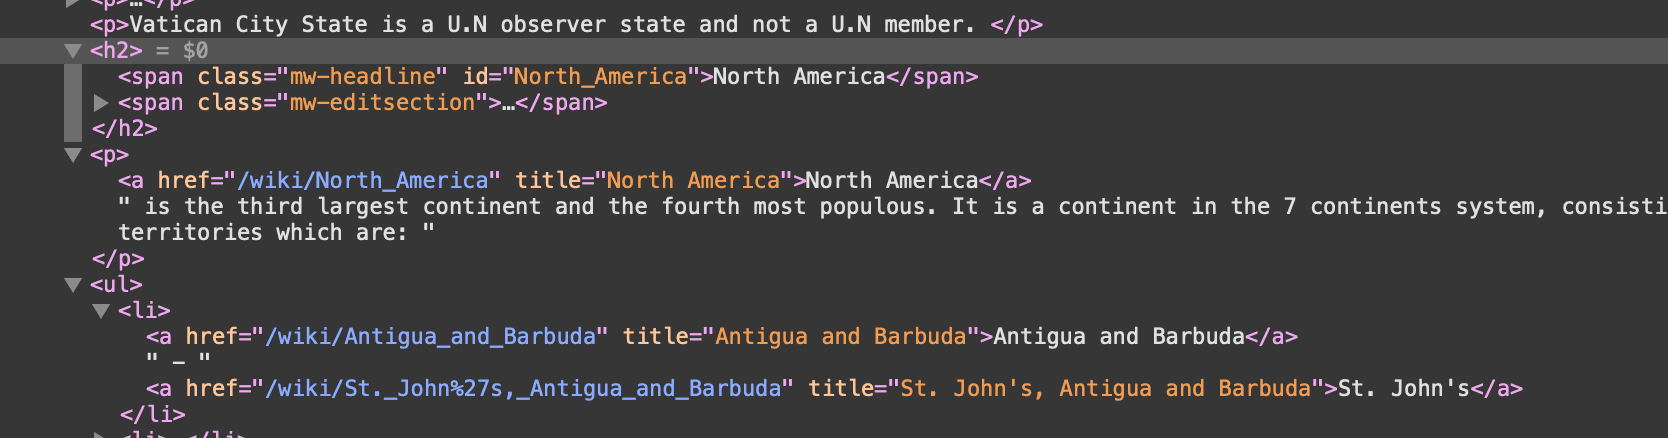

In [4]:
# List of countries and continents, from Wikipedia
# I don't use BeautifulSoup much so prepare for a lot of comments.
countries_list = []
with open(os.path.join('data/countries.html')) as file:
    soup = BeautifulSoup(file, 'lxml')
    
    # first, we loop through to find each continent. 
    for continent in soup.find_all('span', class_='mw-headline')[0:7]:
        # we will change the name "Oceania/Australia" to just "Oceania"
        # which is more universally accepted and standard.
        if (continent.text == "Oceania/Australia"):
            continent_name = "Oceania"
        else:
            continent_name = continent.text
        
        # for each continent, we will keep finding siblings until we find
        # a header tag that indicates we've hit the next continent
        for sibling in continent.parent.next_siblings:
            # Soup errs with attribute checks on NavigableString objects
            if isinstance(sibling, NavigableString) == False:
                # a header means we're done with the current continent
                if sibling.name == "h2":
                    break
                    
                # find all <li> tags in children of current pointer location
                # and if it has a link, store the text from it.
                for country in sibling.find_all('li'):
                    if country.a != None:
                        country_name = country.a.text
                        countries_list.append([country_name, continent_name]) 

# print a test slice of our list of lists.
print(len(countries_list), countries_list[-30:])

232 [['Guyana', 'South America'], ['Paraguay', 'South America'], ['Peru', 'South America'], ['South Georgia and the South Sandwich Islands', 'South America'], ['Suriname', 'South America'], ['Uruguay', 'South America'], ['Venezuela', 'South America'], ['Australia', 'Oceania'], ['Federated States of Micronesia', 'Oceania'], ['Fiji', 'Oceania'], ['Kiribati', 'Oceania'], ['Marshall Islands', 'Oceania'], ['Nauru', 'Oceania'], ['New Zealand', 'Oceania'], ['Palau', 'Oceania'], ['Papua New Guinea', 'Oceania'], ['Samoa', 'Oceania'], ['Solomon Islands', 'Oceania'], ['Tonga', 'Oceania'], ['Tuvalu', 'Oceania'], ['Vanuatu', 'Oceania'], ['Australia', 'Oceania'], ['Flores', 'Oceania'], ['Lombok', 'Oceania'], ['Melanesia', 'Oceania'], ['New Caledonia', 'Oceania'], ['New Guinea', 'Oceania'], ['Sulawesi', 'Oceania'], ['Sumbawa', 'Oceania'], ['Timor', 'Oceania']]


In [5]:
le.head(2), th.head(2), pp.head(2)

(             1800  1801  1802  1803  1804  1805  1806  1807  1808  1809  ...  \
 country                                                                  ...   
 Afghanistan  28.2  28.2  28.2  28.2  28.2  28.2  28.1  28.1  28.1  28.1  ...   
 Albania      35.4  35.4  35.4  35.4  35.4  35.4  35.4  35.4  35.4  35.4  ...   
 
              2091  2092  2093  2094  2095  2096  2097  2098  2099  2100  
 country                                                                  
 Afghanistan  76.5  76.6  76.7  76.9  77.0  77.1  77.3  77.4  77.5  77.7  
 Albania      87.4  87.5  87.6  87.7  87.8  87.9  88.0  88.1  88.2  88.3  
 
 [2 rows x 301 columns],
               1995   1996   1997   1998   1999   2000   2001   2002   2003  \
 country                                                                      
 Afghanistan    NaN    NaN    NaN    NaN    NaN    NaN    NaN   22.1   29.7   
 Albania      106.0  146.0  156.0  184.0  225.0  266.0  279.0  303.0  326.0   
 
               2004   2005   

We can see that the data is all by year, and we do see NaNs for some countries for some years. We'll need to pick a year in order to perform 2d analysis on this data. Let's find the most modern year that has the most data (fewest NaNs) for all the variables I'd like to explore.

In [6]:
HIGH = '2015'
LOW = '2005'

# First we get a count of NaNs by year
nan_list = le.loc[:,LOW:HIGH].isna().sum() \
    + ic.loc[:,LOW:HIGH].isna().sum() \
    + op.loc[:,LOW:HIGH].isna().sum() \
    + th.loc[:,LOW:HIGH].isna().sum() \
    + pp.loc[:,LOW:HIGH].isna().sum() \
# currently unused tables
#    + gs.loc[:,LOW:HIGH].isna().sum() \
#    + ps.loc[:,LOW:HIGH].isna().sum() \

# then make a list of only columns with the min NaN count...
nan_list_mins = nan_list[nan_list == nan_list.min()]

# if we return the last rows index, that should mean the most recent year
# since our data is already sorted by year
year = str(nan_list_mins.tail(1).index[0])
year

'2009'

Now we need to drop all years from all gapminder tables except the selected year, then change the names from the year into more helpful values.

In [7]:
# This function strips all but one year, but could easily be modified
# to keep a list of years if a 3d analysis is needed.
def keep_one_year(df, year):
    year_mask = (df.columns.values == year)
    return df.loc[:, year_mask]

# Now we apply it to each table
le = keep_one_year(le, year)
ic = keep_one_year(ic, year)
op = keep_one_year(op, year)
th = keep_one_year(th, year)
pp = keep_one_year(pp, year)

le.rename(columns = {year:'le'}, inplace = True)
ic.rename(columns = {year:'ic'}, inplace = True)
op.rename(columns = {year:'op'}, inplace = True)
th.rename(columns = {year:'th'}, inplace = True)
pp.rename(columns = {year:'pp'}, inplace = True)

# test a table
le.head()

# currently unused tables
#gs = keep_one_year(gs, year)
#ps = keep_one_year(ps, year)
#gs.rename(columns = {'2001':'gs'}, inplace = True)
#ps.rename(columns = {'2001':'ps'}, inplace = True)

,le
country,
Afghanistan,59.3
Albania,77.5
Algeria,76.1
Andorra,82.2
Angola,59.1


We are finally ready to merge! We will do a left join because the life expectancy data is the piont of the study, so that field is required. I'll handle nulls in the other columns as I go. I have a validation step to make sure everybody is on board.

In [8]:
#df = []
df_init = le.join([ic, op, th, pp], how='left')

# for a validation spot check, I'm essentially building a row of the joined table
# from the individual tables and then comparing it to the master table.
TEST_COUNTRY = 'Angola'
spot_check = [le.loc[TEST_COUNTRY].values[0], \
              ic.loc[TEST_COUNTRY].values[0], op.loc[TEST_COUNTRY].values[0], \
              th.loc[TEST_COUNTRY].values[0], pp.loc[TEST_COUNTRY].values[0]]
if np.array_equal(np.array(df_init.loc[TEST_COUNTRY].values), np.array(spot_check)):
    print("Master table data validated")
else:
    print("Error in master table construction")

Master table data validated


Now we need to add our list of universal healthcare countries to the list. I will need to change some of the names by hand because the country names aren't stable and differ in use of unicode, etc., but let's take of the ones that are an exact match and see what's left.

In [9]:
df_init['uhc'] = False
unmatched = []
for name in uhc_list:
    if name in df_init.index.values:
        df_init.loc[name, 'uhc'] = True
    else:
        unmatched.append(name)
print("UNMATCHED ITEMS")
print(unmatched)
print("UNMATCHED COUNTRY LIST")
print(df_init[df_init.uhc == False].index.values)

UNMATCHED ITEMS
['Africa', 'Americas', 'The Bahamas', 'Asia', 'Hong Kong', 'Macau', "People's Republic of China", 'Taiwan', 'Europe', 'Guernsey / Jersey', 'Isle of Man', 'Russia and Soviet Union', 'England', 'Northern Ireland', 'Scotland', 'Wales', 'Oceania']
UNMATCHED COUNTRY LIST
['Afghanistan' 'Andorra' 'Angola' 'Antigua and Barbuda' 'Armenia'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belize' 'Benin' 'Bolivia' 'Bosnia and Herzegovina' 'Brunei' 'Bulgaria'
 'Burundi' 'Cambodia' 'Cameroon' 'Cape Verde' 'Central African Republic'
 'Chad' 'China' 'Comoros' 'Congo, Dem. Rep.' 'Congo, Rep.' "Cote d'Ivoire"
 'Cyprus' 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji'
 'Gabon' 'Gambia' 'Grenada' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana'
 'Haiti' 'Honduras' 'Hungary' 'Indonesia' 'Iran' 'Iraq' 'Jamaica' 'Jordan'
 'Kazakhstan' 'Kenya' 'Kiribati' 'Kuwait' 'Kyrgyz Republic' 'Lao' 'Latvia'
 '

Our matching algorithm did a pretty good job. I see the The Bahamas, The UK, and China didn't match. Let's fix those by hand.

In [10]:
df_init.loc[['Bahamas', 'China', 'United Kingdom'], 'uhc'] = True
print("Sum of countries with universal healthcare in our study is:", df_init.uhc.sum())

Sum of countries with universal healthcare in our study is: 58


Our last merge is to add the continent information. We'll do it in essentially the same manner - take care of most of these programatically and then tweak what we need to by hand.

In [11]:
df_init['continent'] = ''
unmatched = []
for country, continent in countries_list:
    if country in df_init.index.values:
        df_init.loc[country, 'continent'] = continent
        # print(country, "WAS a match, ", df.loc[name].continent)
    else:
        # print(country, " was not a match")
        unmatched.append(country)
print(f"There are {df_init[df_init.continent == ''].shape[0]} countries without a continent assigned:")
print(df_init[df_init.continent == ''].index.values)

There are 15 countries without a continent assigned:
['Bahamas' 'Congo, Dem. Rep.' 'Congo, Rep.' "Cote d'Ivoire" 'Gambia'
 'Ireland' 'Kyrgyz Republic' 'Lao' 'Micronesia, Fed. Sts.'
 'Sao Tome and Principe' 'Slovak Republic' 'St. Lucia'
 'St. Vincent and the Grenadines' 'Timor-Leste' 'United States']


In [12]:
africa = ['Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", \
          'Gambia', 'Sao Tome and Principe']
asia = ['Lao', 'Kyrgyz Republic']
europe = ['Ireland', 'Slovak Republic']
north_america = ['United States', 'Bahamas', 'Timor-Leste', 'St. Vincent and the Grenadines', 'St. Lucia']
oceania = ['Micronesia, Fed. Sts.']

df_init.loc[africa, 'continent'] = 'Africa'
df_init.loc[asia, 'continent'] = 'Asia'
df_init.loc[europe, 'continent'] = 'Europe'
df_init.loc[north_america, 'continent'] = 'North America'
df_init.loc[oceania, 'continent'] = 'Oceania'

if df_init[df_init.continent == ''].shape[0] == 0:
    print("Success - all countries have a continent")
else:
    print("There's been an error")
    print(f"There are {df_init[df_init.continent == ''].shape[0]} countries without a continent assigned:")
    print(df_init[df_init.continent == ''].index.values)

Success - all countries have a continent


Now let's make a backup before we begin further cleaning and analysis.

In [13]:
df = df_init.copy()

df.head(), df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 187 entries, Afghanistan to Zimbabwe
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   le         187 non-null    float64
 1   ic         187 non-null    float64
 2   op         143 non-null    float64
 3   th         182 non-null    float64
 4   pp         187 non-null    int64  
 5   uhc        187 non-null    bool   
 6   continent  187 non-null    object 
dtypes: bool(1), float64(4), int64(1), object(1)
memory usage: 10.4+ KB


(               le       ic    op      th        pp    uhc continent
 country                                                            
 Afghanistan  59.3   1500.0  83.1    45.6  28400000  False      Asia
 Albania      77.5   9530.0  58.7   592.0   2970000   True    Europe
 Algeria      76.1  12700.0  19.6   365.0  35300000   True    Africa
 Andorra      82.2  41700.0  22.4  3400.0     84500  False    Europe
 Angola       59.1   6290.0  10.1   297.0  22500000  False    Africa,
 None,
                le             ic          op           th            pp
 count  187.000000     187.000000  143.000000   182.000000  1.870000e+02
 mean    70.210695   16013.283422   33.848252  1035.356593  3.655034e+07
 std      8.705072   18255.848570   20.385050  1375.068088  1.374308e+08
 min     44.900000     615.000000    3.510000    15.900000  5.630000e+04
 25%     63.300000    3185.000000   16.200000   136.750000  2.075000e+06
 50%     72.900000    9380.000000   30.100000   478.500000  8.150000e+0

### What is the structure of your dataset?

> A LOT of cleaning and wrangling has been done at this point to grind this table to a dataframe of 187 rows and 7 columns, each of which is pulled form a separate table or scraped from a separate webpage. The data is 5 numeric variables (4 float, 1 int), 1 bool, 1 string. There are 44 and 5 missing values from two float tables, thre rest are fully non-null

### What is/are the main feature(s) of interest in your dataset?

> I'll be looking at the relationship between life expectancy and other variables.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> I can look at life expectancy through a few different lenses - the overall money spent on health, the government's participation in healthcare spending, the location of the country, and how wealthy it is. These are a broader set of indicators than, say, looking at only economic factors. The categorical data I've added will help me look at the data via violin and facet charts.

## Univariate Exploration

> Let's look at our most important variable, life expectancy.

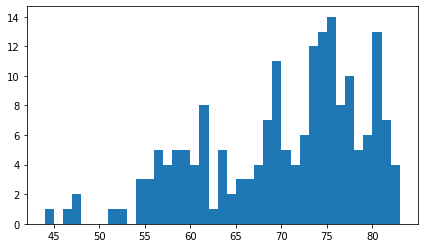

In [14]:
# for all these histograms I'd like to determine my bins programmatically, 
# because that way I can ensure I won't lose any outlier data by accident.
# I will keep the bin size as a constant however based on the look of the graph
BIN_SIZE = 1

plt.figure(figsize = [7, 4])
bins_list = np.arange(int(df['le'].min()), int(df['le'].max()) + BIN_SIZE, BIN_SIZE)
plt.hist(data = df, x = 'le', bins=bins_list);

> We see a moderately right shifted unimodal distribution, suggesting a logarithmic effect that we'd expect thinking about the nhuman lifespan. The most like an outlier in our data is the first four values, although those aren't so far off that they really skew our visualization. Let's look at income next.

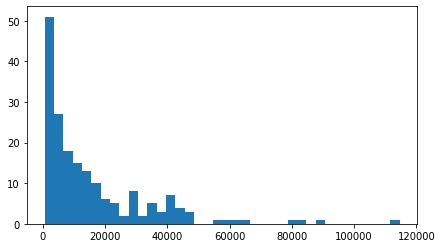

In [15]:
BIN_SIZE = 3000

plt.figure(figsize = [7, 4])
bins_list = np.arange(int(df['ic'].min()), int(df['ic'].max()) + BIN_SIZE, BIN_SIZE)
plt.hist(data = df, x = 'ic', bins=bins_list);

The extreme left shift of this data suggests an exponential distribution. Let's make a log transformation.

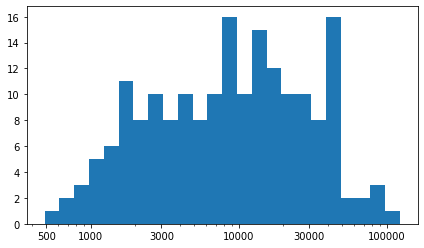

In [16]:
BIN_SIZE = .1

plt.figure(figsize = [7, 4])
bins_list = 10 ** np.arange(np.log10(df['ic'].min()) - BIN_SIZE, np.log10(df['ic'].max()) + BIN_SIZE, BIN_SIZE)
plt.hist(data = df, x = 'ic', bins = bins_list)
plt.xscale('log')
#plt.xlim(500, 130000)
tick_locs = [500, 1000, 3000, 10000, 30000, 100000]
plt.xticks(tick_locs, tick_locs);

This looks more like a standard distribution, and gives us a more meaningful spread. Let's look at a couple more - continent distribution and universal healthcare, both categorical. First, we'll need to make a second dataframe with an added column that is a conversion of the uhc bool into a string.

In [20]:
df_g = df
df_g["uhc_str"] = np.where(df_g.uhc == True, 'Universal Healthcare', 'No Universal Healthcare')
df_g.head()

,le,ic,op,th,pp,uhc,continent,uhc_str
country,,,,,,,,
Afghanistan,59.3,1500.0,83.1,45.6,28400000,False,Asia,No Universal Healthcare
Albania,77.5,9530.0,58.7,592.0,2970000,True,Europe,Universal Healthcare
Algeria,76.1,12700.0,19.6,365.0,35300000,True,Africa,Universal Healthcare
Andorra,82.2,41700.0,22.4,3400.0,84500,False,Europe,No Universal Healthcare
Angola,59.1,6290.0,10.1,297.0,22500000,False,Africa,No Universal Healthcare


''

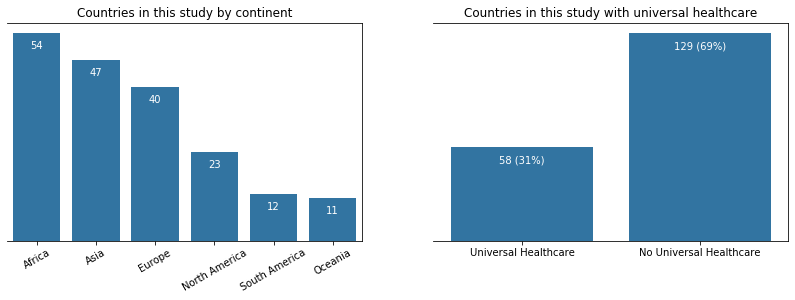

In [58]:
# create a figure and select a color for all bars
plt.figure(figsize = [14, 4])
base_color = sb.color_palette()[0]

###### GRAPH 1
plt.subplot(1, 2, 1)
# sort by count
ax1 = sb.countplot(data = df_g, x = 'continent', color = base_color, \
                  order = df_g['continent'].value_counts().index)

# add annotations
n_points = df_g.shape[0]
cat_counts = df_g['continent'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels
for loc, label in zip(locs, labels):
    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{}'.format(count)
    # print the annotation just below the top of the bar
    plt.text(loc, count-4, pct_string, ha = 'center', color = 'w')

# make label and aesthetic changes
plt.title("Countries in this study by continent")
plt.xticks(rotation = 30)
ax1.set(xlabel="", ylabel = "")
# plt.xlabel("")
# plt.ylabel("")
ax1.set_yticks([])


###### GRAPH 2
plt.subplot(1, 2, 2)
# graph is most readable with uhc first.
cat_list = ['Universal Healthcare', 'No Universal Healthcare']
ax2 = sb.countplot(data = df_g, x = 'uhc_str', color = base_color, \
                  order = cat_list)

# add annotations
n_points = df_g.shape[0]
cat_counts = df_g['uhc_str'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels
for loc, label in zip(locs, labels):
    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{} ({:0.0f}%)'.format(count, 100*count/n_points)
    # print the annotation just below the top of the bar
    plt.text(loc, count-10, pct_string, ha = 'center', color = 'w')

# make label and aesthetic changes
plt.title("Countries in this study with universal healthcare")
ax2.set(xlabel="", ylabel = "")
ax2.set_yticks([])
# plt.xlabel("")
# plt.ylabel("")
;

We can see about a factor of 5 in our country counts by continent, and about a factor of 2 difference in our uhc/no uhc data. These are big differences, but not so large that I think a comparison by continent or by uhc/no uhc wouldn't be valid.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!